# Определение возраста покупателей

Сетевой супермаркет внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

-	Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
-	Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В  распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

### Загружаем библииотеки для анализа

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# игнорирование предупреждений
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")

In [3]:
#константа
RANDOM_SIZE=12345

### Загружаем и получаем информацию о датасете

**Считаем данные из csv-файлов в датафрейм и сохраним в переменные data.**

Данные взяты с сайта ChaLearn Looking at People. Они находятся в папке /datasets/faces/. 
В вашем распоряжении одна папка со всеми изображениями (/final_files) и CSV-файл labels.csv с двумя колонками: file_name и real_age. 


In [4]:
data = pd.read_csv('/datasets/faces/labels.csv')

**Функция по выводу основной информации по датафреймам**

In [5]:
def all_info(data):

    
    print('\033[1m'+'1.Вывод первых 5 строк датафрейма'+'\033[0m')
    print('')
    display(data.head())
    print('')
    
    print('\033[1m'+'2.Разбер выборки.'+'\033[0m')
    print('')
    print(data.shape)
    print('')
    
    print('\033[1m'+'3.Выведим основную информацию о датафрейме.'+'\033[0m')
    print('')
    display(data.info())
    print('')
    
    print('Посмотрим на уникальные значения в столбцах базы данных.')
    print('')
    for i in data.columns:
        print('Кол-во уникальных значений в столбце', i, ':', data[i].nunique())
        print(pd.Series(data[i]).sort_values().unique())
        print('')
    
    
    a = []
    b = []
    c = []
    count = 0
    for value in data.columns:
        a.append(data[value].isna().sum())
        b.append((data[value].isna().sum()/len(data))*100)
        c.append(value)
        count += 1

    f = pd.DataFrame( {'name_columns': pd.Series(c),
                       'count': pd.Series(a),
                      'count,%': pd.Series(b)}
                    )
    print('')
    print('\033[1m'+'4.Таблица пропусков по столбцам.'+'\033[0m')
    print('')
    display(f.sort_values(by=['count'], ascending=False))
    print('')
    print('Колв-во столбцов с пропусками:', len(f[f['count']>0]))
    print('')
    
    print('\033[1m'+'5.Кол-во уникальных дупликатов.'+'\033[0m')
    print('')
    print('Уникальных дупликатов:', data.duplicated().sum())
    print('')
    
    
    print('\033[1m'+'6.Выведим общую информацию о данных в столбцах.'+'\033[0m')
    print('')
    display(data.describe().T)
    print('')
    
    
    print('\033[1m'+'7.Построение общей гистограммы для всех числовых столбцов таблицы'+'\033[0m')
    print('')
    data.hist(bins = 100, figsize=(15, 10))
    plt.title('График распределения кол-ва фотографий по возрастам')
    plt.xlabel('Возраст') 
    plt.ylabel('Кол-во фотографий') 
    plt.show()
    print('')
    
    print('\033[1m'+'8.Построение "ящика с усами"'+'\033[0m')
    print('')
    sns.boxplot(data["real_age"])
    plt.title('График "ящика с усами" для столбца real_age')
    plt.xlabel('Возраст') 

1.Вывод первых 5 строк датафрейма



,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17



2.Разбер выборки.

(7591, 2)

3.Выведим основную информацию о датафрейме.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


None


Посмотрим на уникальные значения в столбцах базы данных.

Кол-во уникальных значений в столбце file_name : 7591
['000000.jpg' '000001.jpg' '000002.jpg' ... '007610.jpg' '007611.jpg'
 '007612.jpg']

Кол-во уникальных значений в столбце real_age : 97
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  93  94  95  96  97 100]


4.Таблица пропусков по столбцам.



,name_columns,count,"count,%"
0,file_name,0,0.0
1,real_age,0,0.0



Колв-во столбцов с пропусками: 0

5.Кол-во уникальных дупликатов.

Уникальных дупликатов: 0

6.Выведим общую информацию о данных в столбцах.



,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0



7.Построение общей гистограммы для всех числовых столбцов таблицы



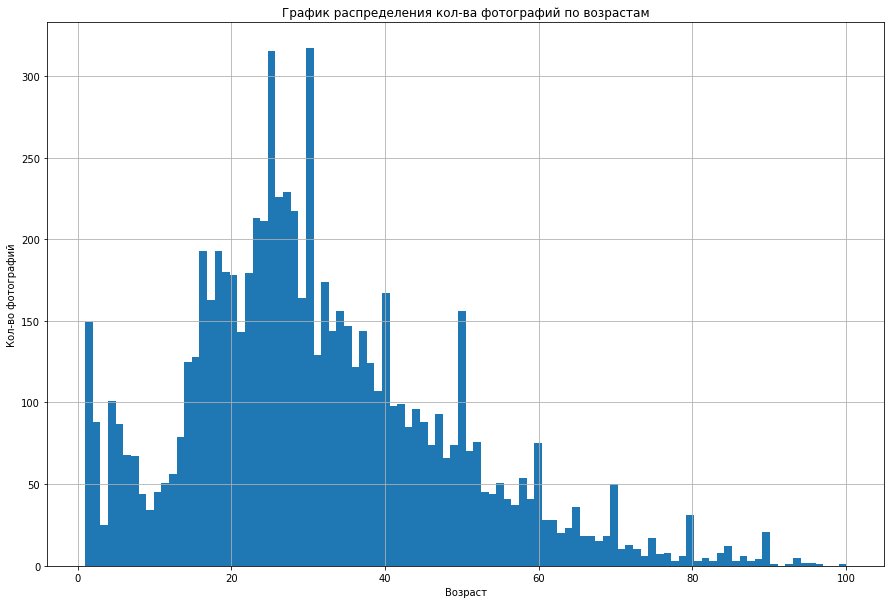


8.Построение "ящика с усами"



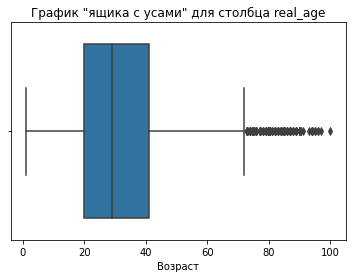

In [6]:
all_info(data)

**Описание данных**

**Признаки**
- **file_name** — изображения

**Целевой признак**
- **real_age** — возраст 

По выведеным данным можно сказать следующее:
- Разбер выборки: (7591, 2)
- Строк: 7591. Столбцов: 2
- Кол-во столбцов с пропусками: 0. 
- Кол-во уникальных значений в столбце file_name : 7591
- Кол-во уникальных значений в столбце real_age : 97. Минимальный 1, а максимальный 100. В данном датасете отсутвует возрасты 92,98 и 99 лет.
- Также при сортировке и выводе уникальных значений в столбце file_name было замечено, что первый файл называется '000000.jpg', а последний '007612.jpg'. А так как всего значений 7591 и наблюдается, что наименование  файлов идет с увеличение числа, то можно предположить, что некоторые картинки в датасете отсутвуют или были исключены. И следовательно возможно файлов ориентировочно 21 было потеряно или исключено. А учитывая, что в выборке отсутвуют возраста 92, 98 и 99 лет, то может быть это и являются нашими потерянными изображениям. 
- столбцы записаны в корректном виде.
- по гистограмме можно наблюдать, что наибольшее кол-во фотографий представлено для людей в возрасте от 20 до 40 лет. Также присутсвует небольшой всплеск в возрасте 1-2 года. Выборка смещена относительн среднего возраста влево.


**Извлечение данных из папки**

In [7]:
labels_datagen = ImageDataGenerator(rescale=1/255.)

In [8]:
labels_datagen_flow = labels_datagen.flow_from_dataframe(
        dataframe=data,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(200, 200),
        batch_size=32,
        class_mode='raw',
        seed=RANDOM_SIZE)

Found 7591 validated image filenames.


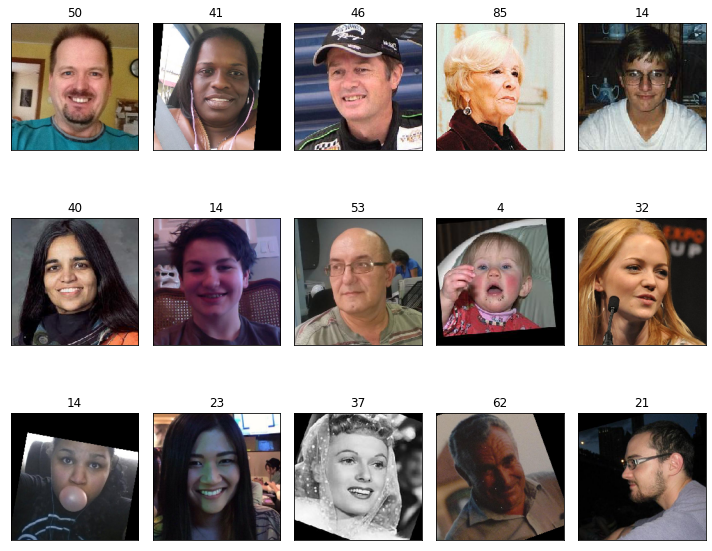

In [9]:
features, target = next(labels_datagen_flow)

# выводим 16 изображений
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.title(target[i])
    plt.imshow(features[i])
	# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()


**Выводы по главе**

В рамках данной была проведена загрузка датасета и проведен его исследовательский анализ.

**Описание данных**

**Признаки**
- **file_name** — изображения

**Целевой признак**
- **real_age** — возраст 

По выведеным данным можно сказать следующее:
- Разбер выборки: (7591, 2)
- Строк: 7591. Столбцов: 2
- Кол-во столбцов с пропусками: 0. 
- Кол-во уникальных значений в столбце file_name : 7591
- Кол-во уникальных значений в столбце real_age : 97. Минимальный 1, а максимальный 100. В данном датасете отсутвует возрасты 92,98 и 99 лет.
- Также при сортировке и выводе уникальных значений в столбце file_name было замечено, что первый файл называется '000000.jpg', а последний '007612.jpg'. А так как всего значений 7591 и наблюдается, что наименование  файлов идет с увеличение числа, то можно предположить, что некоторые картинки в датасете отсутвуют или были исключены. И следовательно возможно файлов ориентировочно 21 было потеряно или исключено. А учитывая, что в выборке отсутвуют возраста 92, 98 и 99 лет, то может быть это и являются нашими потерянными изображениям. 
- столбцы записаны в корректном виде.
- по гистограмме можно наблюдать, что наибольшее кол-во фотографий представлено для людей в возрасте от 20 до 40 лет. Также присутсвует небольшой всплеск в возрасте 1-2 года. Выборка смещена относительн среднего возраста влево.

Также были выведены выборочно 15 изображений.
По представленным предварительным изображениям можно наблюдать, что у нас на изоображении представлены как цветные картинки, так и черно-белые (в градациях серого). Также некоторые изображения выглядят так будт-то подвергнуты были аугментации. Потом на некоторых изображения  лицо людей чем-то загорожено. К примеру у изображения с девушко 14 лет перед лицом надута ею жевачка, а ребенок с 4 годами частично закрывает лицо рукой, а девушку с 32 годами правее лицо перегораживает частично микрофон. Парень в возрасте 21 год на последнем изображении изображен в профиль, что также может сказать на качестве обучении. ТАкже стоит отметить, что на большей часте изображений люди улыбаются.

## Обучение модели

В рамках данного проекта нужно научиться определять возраст человека по фотографии. Седовательно предстоит решить задачу регрессии. Код модели построен на базе сети ResNet50 предобученной на датасете ImageNet с одним нейроном в полносвязной нейронной сети.В качетсве активации был выбран ReLU. с использование алгоритма Adam. Было рассмотрено 5 эпох.

```python

  #импортируем библиотеки для обучения модели
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pathlib
from pathlib import Path
from sklearn.metrics import mean_absolute_error


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, 
                                 horizontal_flip=True,
                                 rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(200, 200),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_gen_flow
 
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25,
                                 horizontal_flip=True,
                                 rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(200, 200),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_gen_flow
 
 
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
 
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer=Adam(learning_rate=0.0001)
 
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae']) 
 
    return model
 
 
def train_model(model, train_data, test_data, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):
 
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
 
    return model

```

```
Train for 356 steps, validate for 119 steps
Epoch 1/5
2023-05-31 19:50:16.802336: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-05-31 19:50:17.102413: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 54s - loss: 207.6527 - mae: 10.4750 - val_loss: 734.8663 - val_mae: 22.1624
Epoch 2/5
356/356 - 45s - loss: 83.9909 - mae: 6.9568 - val_loss: 127.4971 - val_mae: 8.7419
Epoch 3/5
356/356 - 45s - loss: 57.8889 - mae: 5.8222 - val_loss: 77.6854 - val_mae: 6.6753
Epoch 4/5
356/356 - 45s - loss: 41.2095 - mae: 4.9199 - val_loss: 74.3514 - val_mae: 6.6553
Epoch 5/5
356/356 - 44s - loss: 30.9786 - mae: 4.2332 - val_loss: 79.5508 - val_mae: 6.9110
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 11s - loss: 81.4122 - mae: 6.9366
Test MAE: 6.9366


```

## Анализ обученной модели

Необходимо было построить и обучить свёрточную нейронную сеть на датасете с фотографиями людей и добиться значения MAE на тестовой выборке не больше 8, а лучше менее 7. 
Исследуемая модель выше дала результат на тестовой выборке MAE: 6.9366, что соответсвует условию нашей задачи. Для улучшения показателй можно увеличить кол-во эпох. На данный момент их 5.